In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import json
import numpy as np

In [ ]:
FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0)

In [ ]:
df.head()

### Analysis for research question n*1

Graph 1 

In [ ]:
# We remove the movies with no release date since it will be impossible to include them in the time evolution (2619 movies removed)
df_r1 = df[df["release_year"].notna()]
# We remove the movies with no box office value (removed 27030 movies) 34617-7587=27030
df_box_office = df[df["movie_box_office_revenue"].notna()]

In [ ]:
stats = df_r1[["release_year", "movie_box_office_revenue"]].groupby("release_year").describe()
stat_25 = stats.movie_box_office_revenue["25%"]
stat_50 = stats.movie_box_office_revenue["50%"]
stat_75 = stats.movie_box_office_revenue["75%"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(stats.index, stat_25, stat_50, stat_75, labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()


Graph 2

/tmp/ipykernel_75705/204771334.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_character_types = df_character_type.mean().sort_values("movie_box_office_revenue", ascending=False)
/tmp/ipykernel_75705/204771334.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


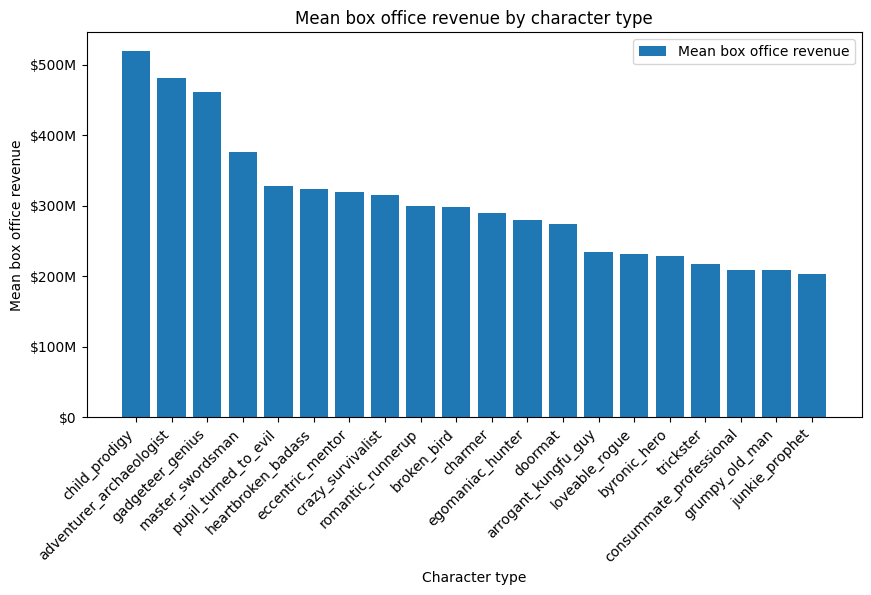

In [78]:

COLUMNS_NAMES_TV_TROPES = [
    "character_type",
    "character_name",
    "movie_name",
    "freebase_id",
    "actor_name",
]
df_character_type = pd.read_csv(FOLDER_PATH + 'tvtropes_processed.csv', header=None, names=COLUMNS_NAMES_TV_TROPES)

# We add the box office revenue for each movie in the character type dataframe
df_character_type["movie_box_office_revenue"] = df_character_type["movie_name"].apply(lambda movie_name: df_box_office[df_box_office["movie_name"] == movie_name]["movie_box_office_revenue"].values)
df_character_type["movie_box_office_revenue"] = df_character_type["movie_box_office_revenue"].apply(lambda x: x[0] if len(x) > 0 else 0)
#TODO: drop movies with 0 as box office_revenue (filter ?)

# We group the dataframe by character type and take the mean of the box office revenue
df_character_type = df_character_type.groupby("character_type")

# We plot the mean box office revenue by character type for the 20 character types with the highest mean box office revenue
fig, ax = plt.subplots(figsize=(10, 5))
top_character_types = df_character_type.mean().sort_values("movie_box_office_revenue", ascending=False)
ax.bar(top_character_types.index[0:20], top_character_types[0:20]["movie_box_office_revenue"], label="Mean box office revenue")
ax.set_xlabel("Character type")
ax.set_ylabel("Mean box office revenue")
ax.set_title("Mean box office revenue by character type")
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.set_major_formatter(currency)
plt.show()

Graph 3 => to be cleaned

/tmp/ipykernel_75705/1232727399.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


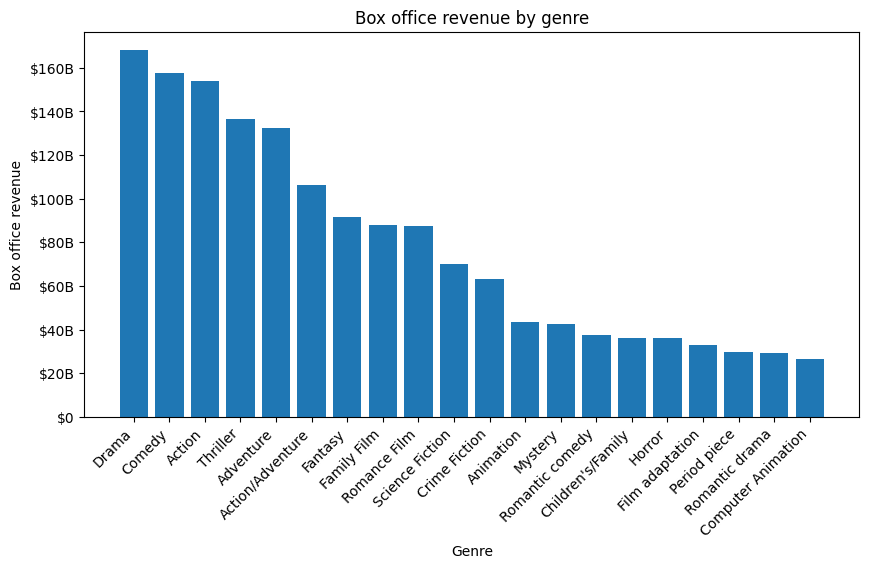

In [76]:
df_genres = df_r1[["movie_box_office_revenue", "genres"]].copy()
df_genres["genres"] = df_genres["genres"].apply(lambda x: literal_eval(x))
genre_and_mean_box_office = df_genres.explode("genres").groupby("genres").sum().sort_values("movie_box_office_revenue", ascending=False)

# We plot the mean box office revenue by genre for the 20 genres with the highest mean box office revenue
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(genre_and_mean_box_office.index[0:20], genre_and_mean_box_office["movie_box_office_revenue"][0:20])
ax.set_xlabel("Genre")
ax.set_ylabel("Box office revenue")
ax.set_title("Box office revenue by genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.set_major_formatter(currency)
plt.show()

The main genders are Drama, Comedy, Action, Thriller and Adventure.
We will go deeper in the analysis with those 5 genres.

In [85]:
df_top_5_genres = df_r1[["movie_box_office_revenue", "genres", "release_year"]].copy()
df_top_5_genres["genres"] = df_top_5_genres["genres"].apply(literal_eval)
df_top_5_genres_grouped = df_top_5_genres.explode("genres").reset_index(drop=True).groupby(["genres","release_year"]).agg({"movie_box_office_revenue": "mean"}).apply(lambda x: x)


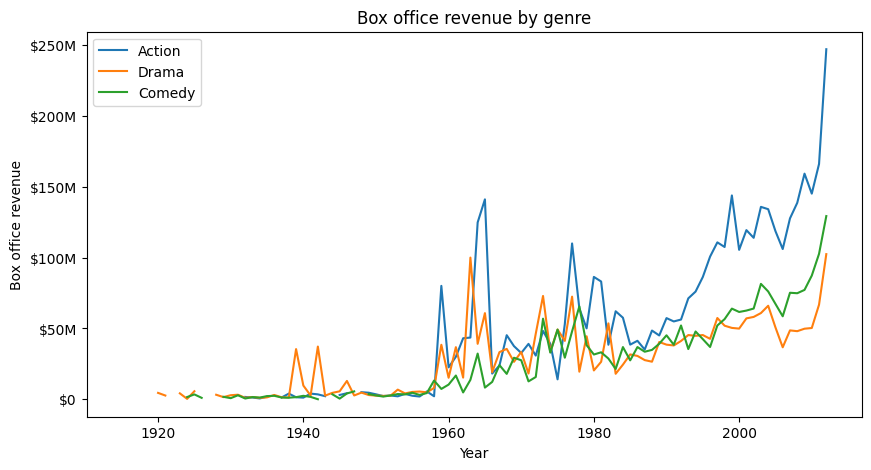

In [88]:
df_action = df_top_5_genres_grouped[df_top_5_genres_grouped.index.get_level_values("genres") == "Action"]
df_drama = df_top_5_genres_grouped[df_top_5_genres_grouped.index.get_level_values("genres") == "Drama"]
df_comedy = df_top_5_genres_grouped[df_top_5_genres_grouped.index.get_level_values("genres") == "Comedy"]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_action.index.get_level_values("release_year"), df_action["movie_box_office_revenue"], label="Action")
ax.plot(df_drama.index.get_level_values("release_year"), df_drama["movie_box_office_revenue"], label="Drama")
ax.plot(df_comedy.index.get_level_values("release_year"), df_comedy["movie_box_office_revenue"], label="Comedy")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")
ax.set_title("Box office revenue by genre")
ax.legend()
ax.yaxis.set_major_formatter(currency)
plt.show()


Restes du festin

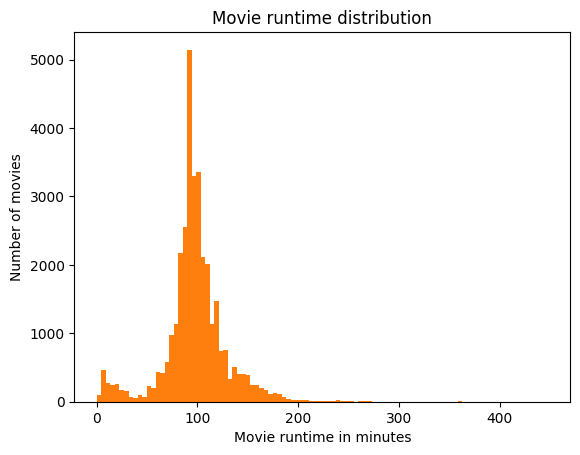

In [95]:
df_r1_clean = df_r1[df_r1["movie_runtime"] < 450].sort_values("movie_runtime", ascending=False)
movie_mean_by_year = df_r1_clean.groupby("release_year")["movie_runtime"].mean()
hist, edges = np.histogram(df_r1_clean["movie_runtime"], bins=100)
colors = np.array(["C0", "C1"])[(edges[:-1] > 0).astype(int)]
plt.bar(edges[:-1], hist, width=np.diff(edges), align="edge", color=colors)
plt.xlabel("Movie runtime in minutes")
plt.ylabel("Number of movies")
plt.title("Movie runtime distribution")
plt.show()

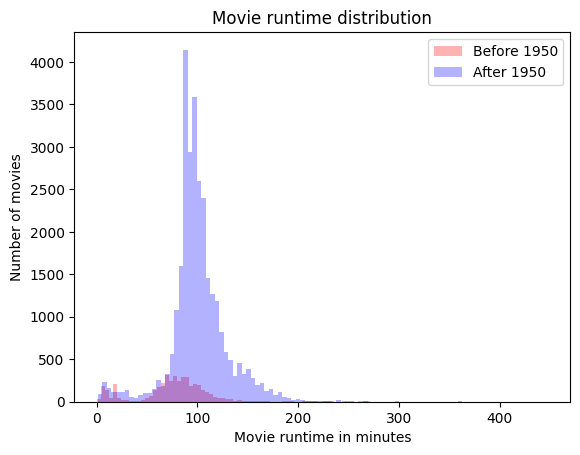

In [96]:
df_r1_clean_1 = df_r1_clean[df_r1_clean.release_year < 1950]
df_r1_clean_2 = df_r1_clean[(df_r1_clean.release_year >= 1950)]

plt.hist(df_r1_clean_1["movie_runtime"], bins=100, color="red", alpha=0.3, label="Before 1950")
plt.hist(df_r1_clean_2["movie_runtime"], bins=100, color="blue", alpha=0.3, label="After 1950")
plt.xlabel("Movie runtime in minutes")
plt.ylabel("Number of movies")
plt.title("Movie runtime distribution")
plt.legend()
plt.show()